# BERT

У нас уже есть очищенный от странных симвлов текст. Мы не делаем лемматизацию. Для работы воспользуемся моделью tblard/tf-allocine. Французская модель, основанная на CamemBERT и оптимизированная на крупномасштабном наборе данных, полученном из отзывов пользователей Allociné.fr.

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
import numpy as np
import pandas as pd

2025-05-16 13:02:32.361015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747400552.567925      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747400552.630186      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
songs_df = pd.read_csv("/kaggle/input/songs2/songs_with_scores.csv", encoding='utf-8-sig')

In [ ]:
model_name = "tblard/tf-allocine"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/445M [00:00<?, ?B/s]

I0000 00:00:1747400570.329870      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747400570.330653      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


Не очень приятно, что есть длинные песни. Что делаем в этом случае? Делим на части и в этом случае смотрим на общее значение всех разделённых частей.

In [ ]:
def get_tf_sentiment_score_chunked(text, chunk_size=512):
    input_ids = tokenizer.encode(text, truncation=False)

    all_probs = []

    for i in range(0, len(input_ids), chunk_size):
        chunk = input_ids[i:i+chunk_size]

        if len(chunk) < 2:
            continue

        inputs = tokenizer.prepare_for_model(
            chunk,
            max_length=chunk_size,
            truncation=True,
            padding='max_length',
            return_tensors='tf'
        )

        if inputs['input_ids'].shape.rank == 1:
            for key in inputs:
                inputs[key] = tf.expand_dims(inputs[key], axis=0)

        outputs = model(inputs)
        logits = outputs.logits
        probs = tf.nn.softmax(logits, axis=1).numpy()[0]
        all_probs.append(probs[1])

    return float(np.mean(all_probs)) if all_probs else None

In [ ]:
songs_df['bert_score'] = songs_df['clean_lyrics'].progress_apply(get_tf_sentiment_score_chunked)

100%|██████████| 6531/6531 [31:40<00:00,  3.44it/s] 


In [ ]:
songs_df.to_csv("songs_with_all_scores.csv", index=False, encoding='utf-8-sig')

# Графики

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [ ]:
songs_df['decade'] = (songs_df['date'] // 10) * 10
decade_counts = songs_df.groupby('author_id')['decade'].nunique()
multi_decade_artists = decade_counts[decade_counts > 2].index
multi_decade_df = songs_df[songs_df['author_id'].isin(multi_decade_artists)]

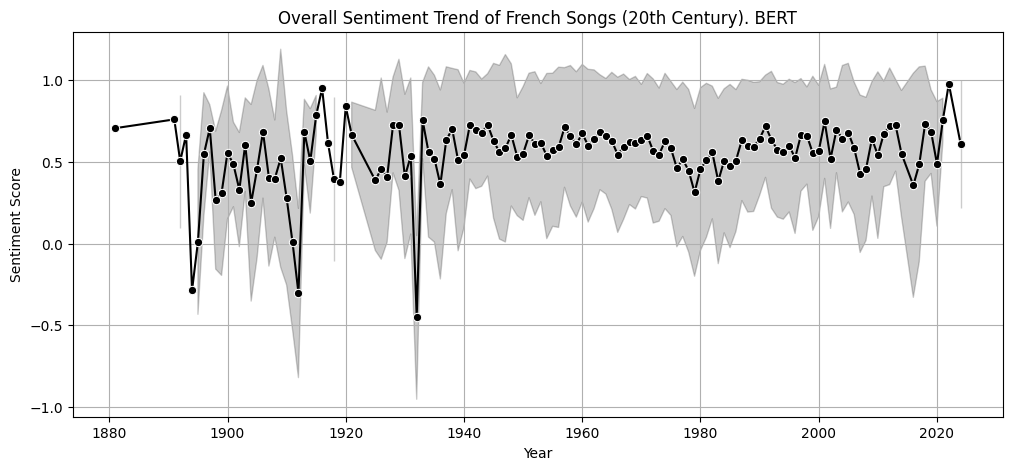

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=songs_df,
    x='date',
    y='auto_score',
    estimator='mean',
    errorbar='sd',
    color='black',
    marker='o'
)
plt.title('Overall Sentiment Trend of French Songs (20th Century). BERT')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.savefig(f"/kaggle/working/sentiment_BERT.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import math

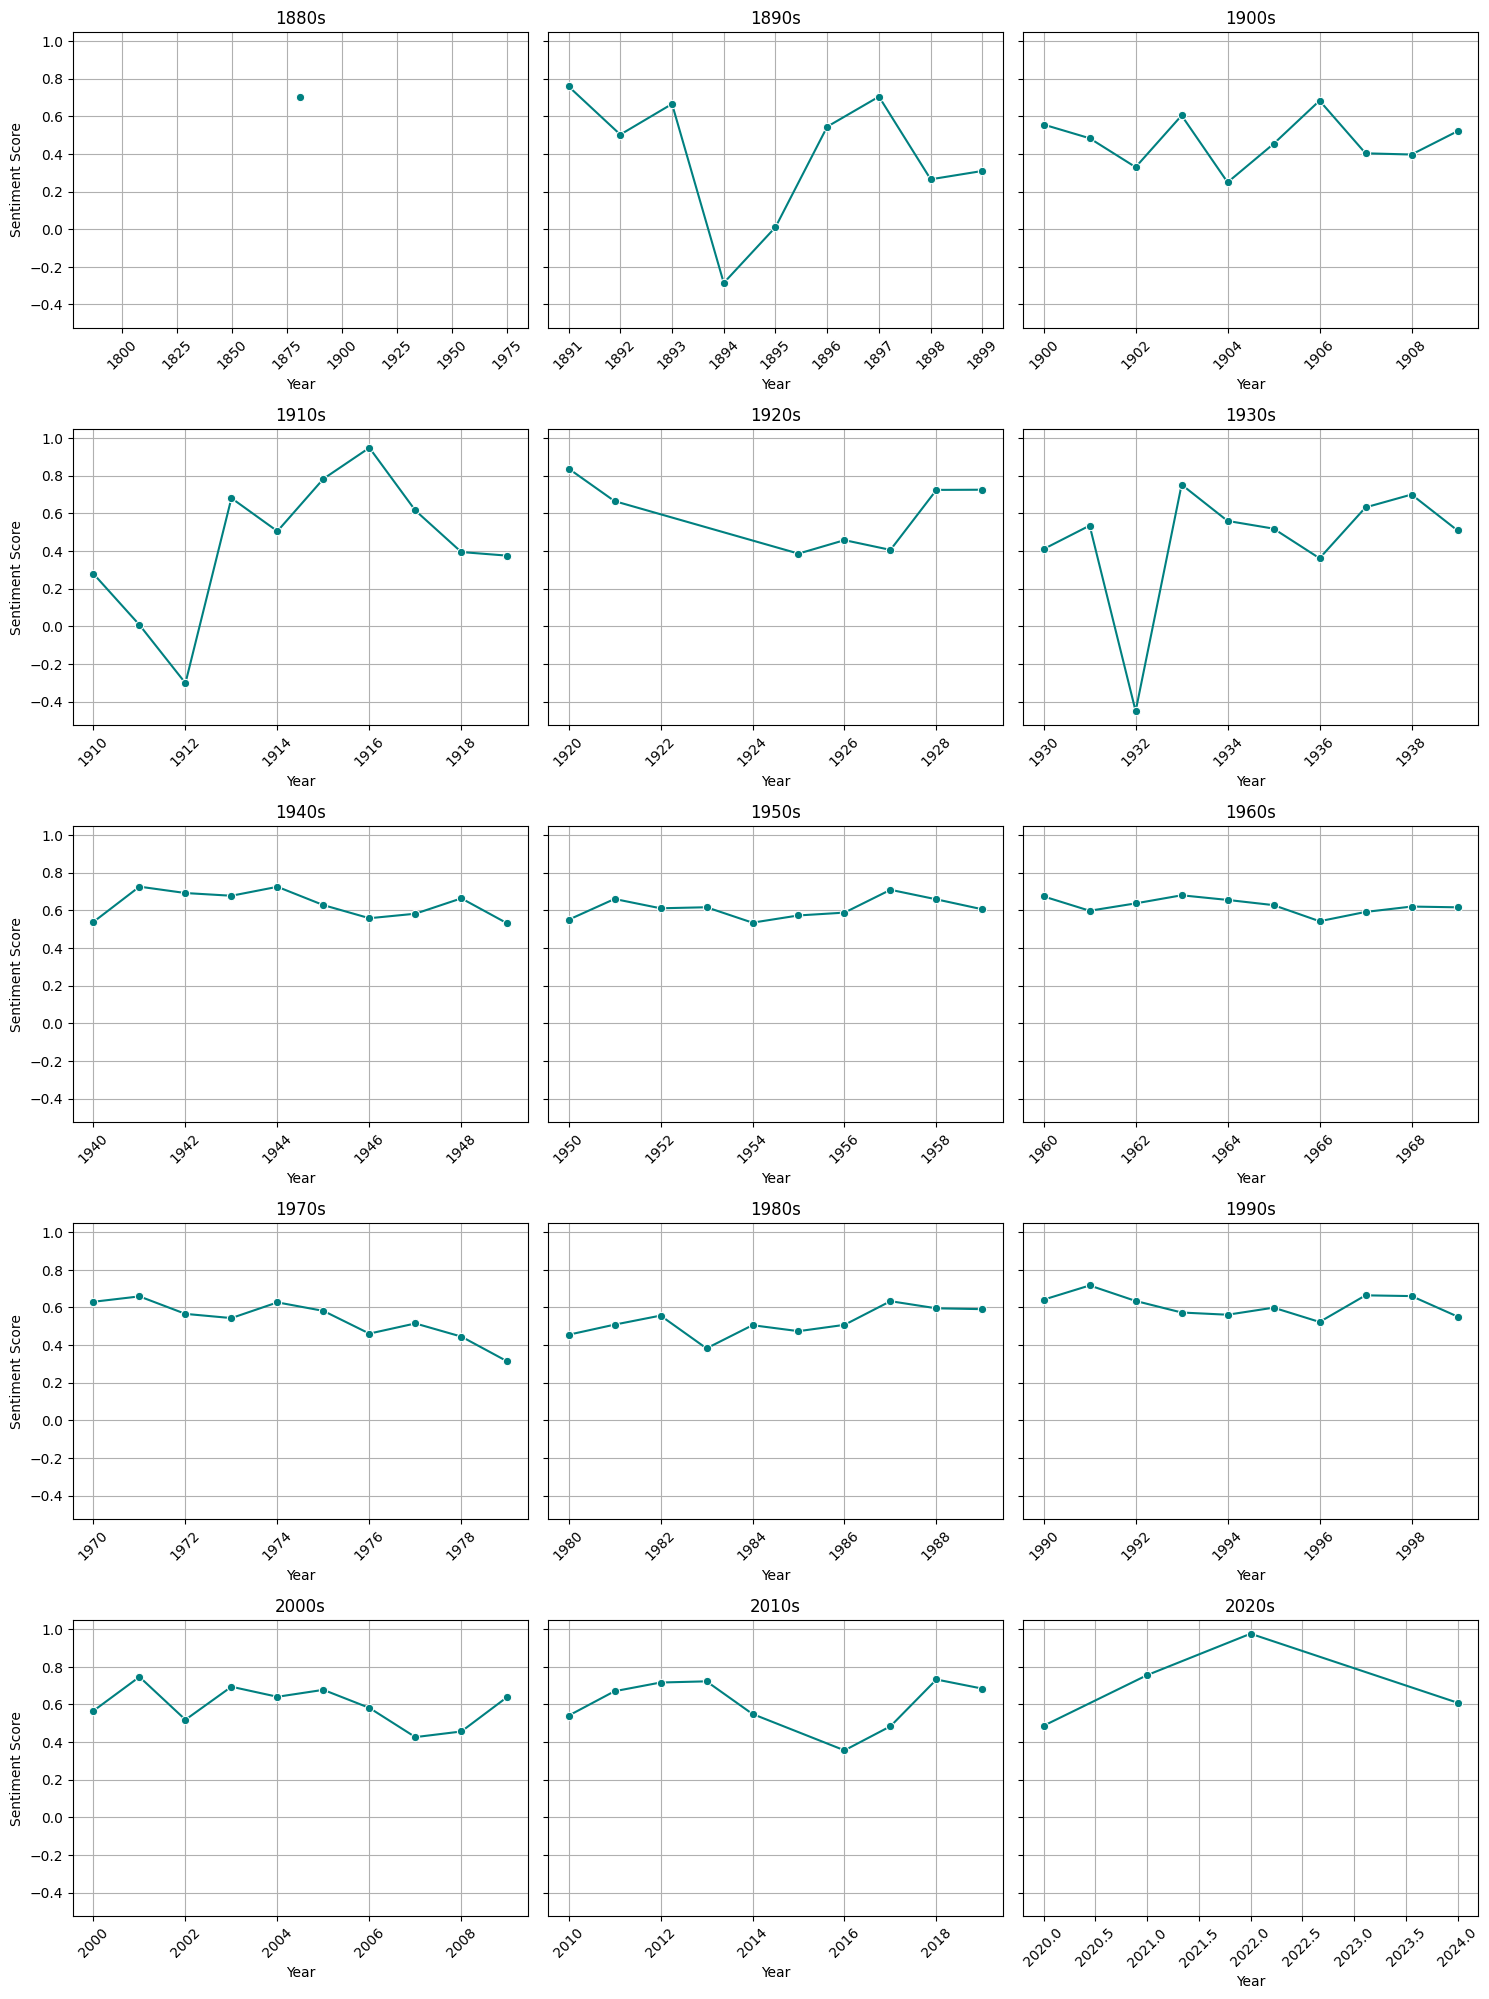

In [ ]:
unique_decades = sorted(songs_df['decade'].dropna().unique())
n_cols = 3
n_rows = math.ceil(len(unique_decades) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), sharey=True)
axes = axes.flatten()

for idx, decade in enumerate(unique_decades):
    dec_df = songs_df[songs_df['decade'] == decade]
    year_sentiment = dec_df.groupby('date')['auto_score'].mean().reset_index()

    sns.lineplot(data=year_sentiment, x='date', y='auto_score', marker='o', ax=axes[idx], color='teal')
    axes[idx].set_title(f"{decade}s")
    axes[idx].set_xlabel("Year")
    axes[idx].set_ylabel("Sentiment Score")
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True)

for ax in axes[len(unique_decades):]:
    ax.axis('off')

plt.tight_layout()
plt.savefig(f"/kaggle/working/sentiment_decades_all BERT.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import sqlite3

In [ ]:
conn = sqlite3.connect("/kaggle/input/songs1/Chanson_franaises_XX_balanced.db")

In [ ]:
authors_df = pd.read_sql_query("SELECT * FROM author", conn)

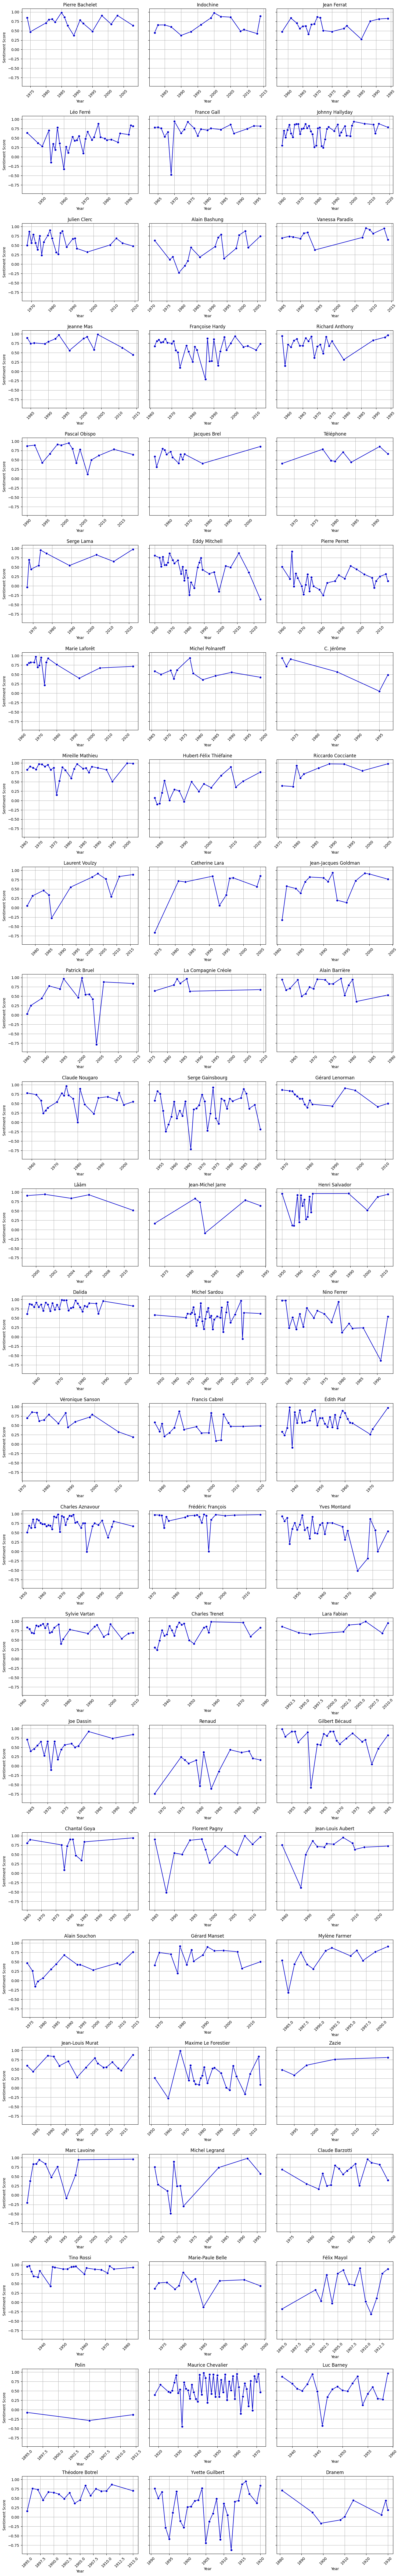

In [ ]:
author_decade_counts = songs_df.groupby('author_id')['decade'].nunique()
active_authors = author_decade_counts[author_decade_counts > 2].index

songs_with_names = songs_df.merge(authors_df, left_on='author_id', right_on='id')

active_songs = songs_with_names[songs_with_names['author_id'].isin(active_authors)]
unique_authors = active_songs['author_id'].unique()
n_authors = len(unique_authors)
n_cols = 3
n_rows = math.ceil(n_authors / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), sharey=True)
axes = axes.flatten()

for idx, author_id in enumerate(unique_authors):
    author_df = active_songs[active_songs['author_id'] == author_id]
    yearly = author_df.groupby('date')['auto_score'].mean().reset_index()
    author_name = author_df['name'].iloc[0]

    sns.lineplot(data=yearly, x='date', y='auto_score', marker='o', ax=axes[idx], color='mediumblue')
    axes[idx].set_title(f"{author_name}")
    axes[idx].set_xlabel("Year")
    axes[idx].set_ylabel("Sentiment Score")
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True)

for ax in axes[len(unique_authors):]:
    ax.axis('off')

plt.tight_layout()
plt.savefig(f"/kaggle/working/sentiment_authors BERT.png", dpi=300, bbox_inches='tight')
plt.show()